In [14]:
import pandas as pd
import urllib
import zipfile
import sys
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt  # for plots
from matplotlib import rc
import seaborn as sns
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
from math import cos, sin, pi, sqrt
from statsmodels.nonparametric.kde import KDEUnivariate
from scipy.linalg import toeplitz
from numpy.linalg import eigh
from sklearn import linear_model
from sklearn import preprocessing as pr
from sklearn.decomposition import PCA
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)
from sklearn import model_selection as ms
from os import mkdir, path
from functools import partial
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV, Lasso, lasso_path
from matplotlib.patches import Polygon, Circle
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import PolynomialFeatures

pd.options.display.max_columns = 100

### Import Data and Split

In [30]:
#
def importdata():
    TestData = pd.read_csv(
        "/home/joseph/Dropbox/DeepLearning/Programmation/KaggleCompetition/test-data.csv", sep=",")
    TrainData = pd.read_csv(
        "/home/joseph/Dropbox/DeepLearning/Programmation/KaggleCompetition/train-data.csv", sep=",")

    return TrainData, TestData


def preprocessdata(TrainData, Train):
    Y = None
    X = TrainData.copy()

    if Train == True:
        Y = TrainData['Cover_Type']
        X.drop(['Cover_Type'], axis=1, inplace=True)

    X.drop(['Id'], axis=1, inplace=True)
#    X.drop(['Wilderness_Area1'], axis=1, inplace=True)
#    X['Distance'] = (X['Horizontal_Distance_To_Hydrology']
#                     ** 2 + X['Vertical_Distance_To_Hydrology']**2)**(1 / 2)
#    X.drop(['Horizontal_Distance_To_Hydrology',
#            'Vertical_Distance_To_Hydrology'], axis=1, inplace=True)

    return X, Y


def ArrangeSoilType(Data):
    ColToDrop = []
    soiltypearray = np.array([99, 27, 27, 27, 27, 27, 27, 35, 35, 42, 47, 47, 47, 47,
                              51, 51, 61, 61, 67, 71, 71, 71, 72, 72, 77, 77, 77,
                              77, 77, 77, 77, 77, 77, 77, 77, 87, 87, 87, 87, 87, 87])
    ColumnsClimdict = {1: 'lower montane dry', 2: 'lower montane', 3: 'montane dry',
                       4: 'montane',  5: 'montane dry and montane', 6: ' montane and subalpine',
                       7: 'subalpine', 8: 'alpine'}
    ColumnsGeodict = {1: 'alluvium', 2: 'glacial', 3: 'shale', 4: 'sandstone', 5: 'mixed sedimentary',
                      6: 'unspecified', 7: 'igneous and metamorphic', 8: 'volcanic'}

    listCol = list(ColumnsClimdict.values())
    listCol.extend(list(ColumnsGeodict.values()))

    for k in ColumnsGeodict.keys():
        p = KeyToName(int(k), int(k), soiltypearray)
        Data[ColumnsClimdict[k]] = Data[p[1]].sum(axis=1)
        Data[ColumnsGeodict[k]] = Data[p[0]].sum(axis=1)

    for x in Data.columns:
        if x[:3:] == 'Soi':
            ColToDrop.append(x)
    # print(ColToDrop)
    #Data.drop(ColToDrop, axis=1, inplace=True)
    # print(Data.describe())
    Data.drop(['sandstone', 'unspecified', 'volcanic',
               'lower montane dry'], axis=1, inplace=True)
    return Data


def RemoveConstantCol(Data):
    Data.drop(['Soil_Type7', 'Soil_Type15'], axis=1, inplace=True)
    return Data


def KeyToName(Climdict, Geodict, soilarray):
    IndexClim = []
    IndexGeo = []
    for counter, value in enumerate(soilarray):
        value = list(str(value))
        if value[0] == str(Climdict):
            IndexClim.append('Soil_Type' + str(counter))
        if value[1] == str(Geodict):
            IndexGeo.append('Soil_Type' + str(counter))

    return IndexGeo, IndexClim


def preprocessTD(TestData):

    X = TestData.copy()
    X.drop(['Wilderness_Area1'], axis=1, inplace=True)
    X.drop(['Id'], axis=1, inplace=True)
#    X['Distance'] = (X['Horizontal_Distance_To_Hydrology']
#                     ** 2 + X['Vertical_Distance_To_Hydrology']**2)**(1 / 2)
#    X.drop(['Horizontal_Distance_To_Hydrology',
#            'Vertical_Distance_To_Hydrology'], axis=1, inplace=True)
    return X


def ScaleData(Xprime):
    # print(Xprime.describe())
    index = []
    index = list(range(0, 8))
    index.append(Xprime.shape[1])
    scaler = pr.StandardScaler(with_mean=True, with_std=True).fit(
        Xprime.loc[:, Xprime.columns[index]])
    #scalerMM= pr.MinMaxScaler();
    #scalerNo= pr.Normalizer();


#    Xprime.iloc[:,0:8:] = scalerMM.fit_transform(Xprime.iloc[:,0:8:])
#    Xprime['Distance'] = scalerMM.fit_transform(Xprime['Distance'].values.reshape(-1,1))
#    Xprime.iloc[:,0:8:] = scalerNo.fit_transform(Xprime.iloc[:,0:8:])
#    Xprime['Distance'] = scalerNo.fit_transform(Xprime['Distance'].values.reshape(-1,1))
    return scaler, index


def Scale1(Data):
    index = []
    index = list(range(0, 8))
    index.append(Xprime.shape[1] - 1)
    D = pr.StandardScaler(with_mean=True, with_std=True).fit_transform(
        Data.loc[:, Data.columns[index]])


def SplitData(X, Y):
    Splits = ms.train_test_split(X, Y, test_size=0.1)
    return Splits


def GridSearchSVM(X, Y, gamma, C, decisions_func, cv):

 #    X[['Horizontal_Distance_To_Fire_Points',
    #       'Horizontal_Distance_To_Roadways']] = np.sqrt(X[['Horizontal_Distance_To_Fire_Points',
    #                                         'Horizontal_Distance_To_Roadways']])
    #    X[['Hillshade_9am','Hillshade_Noon']] = np.square(X[['Hillshade_9am','Hillshade_Noon']])

    #    X = ScaleData(X)
    tuned_parameters = [{'C': C,
                         'kernel': ['rbf'],
                         'decision_function_shape':decisions_func,
                         'gamma':gamma}]
    GS = GridSearchCV(SVC(), tuned_parameters, cv=cv, n_jobs=-1, verbose=1)
    GS.fit(X, Y)
    return GS


def Prediction(Xtrain, Ytrain, mod):
    return mod.predict(Xtrain, Ytrain)


def Error(Ytest, Ypred):
    Err = np.count_nonzero(Ytest - Ypred) / len(Ytest)
    return (1 - Err)


def writeres(X, Y, name):

    Ysub = pd.DataFrame(columns=['Id', 'Cover_Type'])
    Ysub['Cover_Type'] = Y
    Ysub['Id'] = X['Id']
    Ysub.to_csv('/home/joseph/Dropbox/DeepLearning/Programmation/KaggleCompetition/' +
                name, sep=',', index=False)
    print(name, Ysub['Cover_Type'].value_counts())


def ET(X, Y, n, boot, cw, cv):
    #X = ScaleData(X)

    tuned_parameters = [{'n_estimators': n,
                         'bootstrap': boot,
                         'class_weight': cw,
                         'max_features':[None],
                         'random_state':[2617]}]
    clf_ET = GridSearchCV(ExtraTreesClassifier(), tuned_parameters,
                          cv=cv, n_jobs=-1, verbose=1)
    clf_ET.fit(X, Y)

    return clf_ET


def RandomClassifier(X, Y, n, boot, cw, cv):
    #X = ScaleData(X)
    tuned_parameters = [{'n_estimators': n,
                         'bootstrap': boot,
                         'class_weight': cw}]
    clf_RF = GridSearchCV(RandomForestClassifier(),
                          tuned_parameters, cv=cv, n_jobs=-1, verbose=1)
    clf_RF.fit(X, Y)
    return clf_RF


def importandPreprocess(Scale, FE):
    index = []
    Data = importdata()

    if FE:
        TestData = ArrangeSoilType(Data[1])
        TrainData = ArrangeSoilType(Data[0])
        TestData = RemoveConstantCol(TestData)
        TrainData = RemoveConstantCol(TrainData)
    else:
        TestData = RemoveConstantCol(Data[1])
        TrainData = RemoveConstantCol(Data[0])

    TrainDataPrep = preprocessdata(TrainData, True)
    X = TrainDataPrep[0]
    Y = TrainDataPrep[1]
    TestDataPrep = preprocessdata(TestData, False)
    XtestFinal = TestDataPrep[0]
    Splits = SplitData(X, Y)
    Xtrain = Splits[0]
    Xtest = Splits[1]
    Ytrain = Splits[2]
    Ytest = Splits[3]
    #sc = ScaleData(Xtrain)
    scaler = pr.StandardScaler(with_mean=True, with_std=True)
    #index= sc[1]
    idx = list(range(0, 7))
    #idx.append(Xtrain.shape[1] - 1)

    if Scale:
        Xtrain_scale = pd.DataFrame(scaler.fit_transform(Xtrain.loc[:,
                                                                    Xtrain.columns[idx]]), columns=Xtrain.columns[idx], index=Xtrain.index)
        Xtest_scale = pd.DataFrame(scaler.fit_transform(Xtest.loc[:, Xtest.columns[idx]]),
                                   columns=Xtest.columns[idx], index=Xtest.index)

        XtestFinal_scale = pd.DataFrame(scaler.fit_transform(XtestFinal.loc[:,
                                                                            XtestFinal.columns[idx]]), columns=XtestFinal.columns[idx], index=XtestFinal.index)
        Xtrainscale = pd.concat([Xtrain_scale, Xtrain.iloc[:, 7:Xtrain.shape[1] ]],
                                axis=1, )
        Xtestscale = pd.concat([Xtest_scale, Xtest.iloc[:, 7:Xtest.shape[1] ]],
                               axis=1)
        XtestFinalscale = pd.concat([XtestFinal_scale, XtestFinal.iloc[:, 7:Xtest.shape[1] ]],
                                    axis=1)
#       print(Xtrain.shape)
        print(Xtest.columns)
#       print(Xtrainscale.columns)
        print(Xtestscale.columns)
#       print(XtestFinal.shape)
#       print(Xtrainscale.describe())
#       print(Xtestscale.describe())
#       print(XtestFinal.describe())

    return Xtrain, Xtrainscale, Xtest, Xtestscale, Ytrain, Ytest, XtestFinal, TestData, XtestFinalscale

In [32]:
Xtrain, Xtrainscale, Xtest, Xtestscale, Ytrain, Ytest, XtestFinal, TestData, XtestFinalscale = importandPreprocess(
    True, False)
XtrainFE, XtrainscaleFE, XtestFE, XtestscaleFE, YtrainFE, YtestFE, XtestFinalFE, TestDataFE, XtestFinalscaleFE = importandPreprocess(
    True, True)

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11',
       'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40'],
      dtype='object')
Index(['El

In [33]:
TrainDataPrep = pd.concat([Xtrain, Ytrain], axis=1)

In [34]:
TrainDataPrep.groupby('Cover_Type').mean()


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
Cover_Type,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,3129.160760,159.379045,13.212635,270.649204,41.190036,2564.059579,211.393939,223.096559,144.157678,1990.201849,0.487417,0.084746,0.427838,0.000000,0.000000,0.000000,0.000000,0.002054,0.000000,0.000000,0.00000,0.000514,0.004109,0.002054,0.010272,0.008731,0.000000,0.004109,0.001027,0.000000,0.007704,0.017976,0.006163,0.125321,0.177196,0.059065,0.00000,0.003082,0.003595,0.000000,0.186441,0.035953,0.054443,0.103749,0.087314,0.000000,0.001541,0.000000,0.000000,0.037494,0.037494,0.022599
2,2921.197505,150.361227,13.480769,288.166320,47.476091,2443.945946,214.173077,225.312370,142.674636,2150.954782,0.527547,0.028586,0.433992,0.009875,0.000000,0.001040,0.005717,0.009875,0.000000,0.003638,0.00052,0.003638,0.038462,0.031185,0.094075,0.038981,0.000000,0.006237,0.002599,0.006237,0.006757,0.023909,0.000000,0.024428,0.066528,0.033264,0.00052,0.008836,0.002599,0.002079,0.256237,0.070686,0.043139,0.121102,0.086279,0.004678,0.000520,0.001040,0.000000,0.002599,0.001559,0.001040
3,2399.874356,173.726571,20.692070,209.958290,63.385685,975.520082,201.487642,216.578785,141.664779,917.463440,0.000000,0.000000,0.403193,0.596807,0.056128,0.128218,0.060247,0.215242,0.024717,0.114315,0.00000,0.000000,0.333677,0.043254,0.000000,0.002060,0.002060,0.001545,0.015963,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002575,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2222.704807,137.356844,18.567921,104.387670,39.987983,908.870951,228.275340,216.572100,111.049634,859.031348,0.000000,0.000000,0.000000,1.000000,0.063218,0.043365,0.374086,0.064263,0.017764,0.113375,0.00000,0.000000,0.082027,0.010449,0.000000,0.000000,0.059561,0.017241,0.154650,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,2787.771778,139.507896,16.746816,207.862965,50.650025,1334.848192,223.315843,218.490576,121.610800,1531.073867,0.394804,0.000000,0.605196,0.000000,0.000000,0.028528,0.000000,0.061640,0.000000,0.000000,0.00000,0.000000,0.031584,0.070810,0.000000,0.140601,0.000000,0.004585,0.062150,0.018849,0.008660,0.002038,0.000000,0.000000,0.070301,0.005094,0.00000,0.013245,0.000000,0.001528,0.116149,0.223637,0.040245,0.043301,0.055018,0.002038,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,2422.422822,182.215996,18.975038,159.966887,44.695364,1060.182883,193.425369,210.099338,148.003057,1057.846154,0.000000,0.000000,0.442180,0.557820,0.044829,0.080998,0.009170,0.042282,0.033622,0.071319,0.00000,0.000000,0.505858,0.031075,0.000000,0.030565,0.017320,0.016811,0.042282,0.000000,0.000000,0.018849,0.000000,0.000000,0.001019,0.006623,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003566,0.012226,0.030565,0.001019,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,3361.511509,154.967263,14.145269,345.294118,68.428133,2714.357033,216.729923,222.437340,136.209207,2067.953964,0.257289,0.117136,0.625575,0.000000,0.000000,0.000000,0.000000,0.003581,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

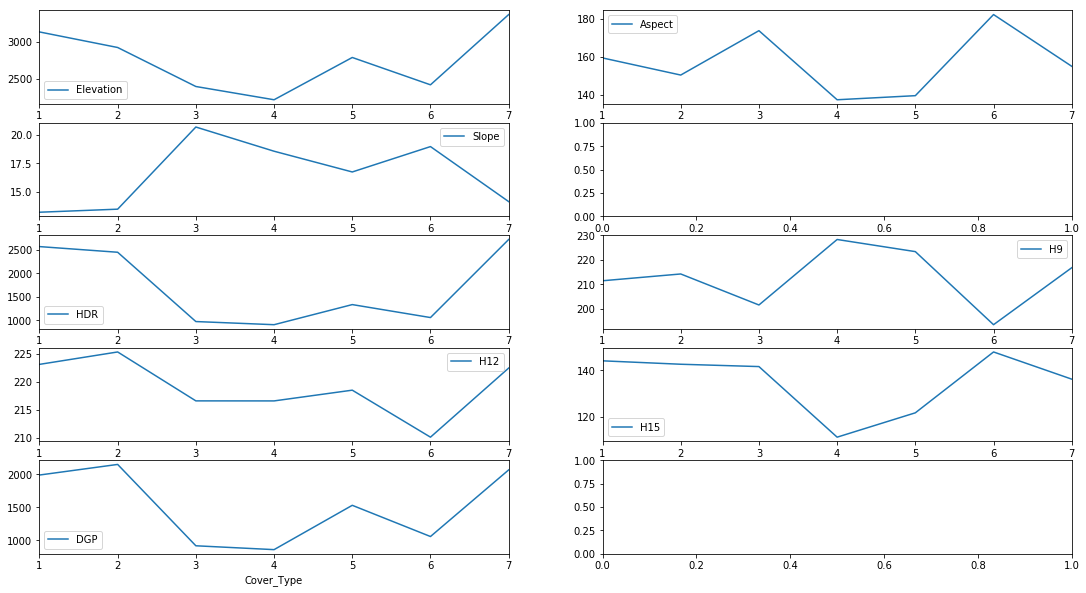

In [35]:
%matplotlib inline
fig, axs = plt.subplots(figsize=(18.5,10),ncols=2,nrows=5)

TrainDataPrep.groupby('Cover_Type').mean().Elevation.plot(ax=axs[0,0], label='Elevation').legend()
TrainDataPrep.groupby('Cover_Type').mean().Aspect.plot(ax=axs[0,1], label='Aspect').legend()
TrainDataPrep.groupby('Cover_Type').mean().Slope.plot(ax=axs[1,0], label='Slope').legend()
#TrainDataPrep.groupby('Cover_Type').mean().Distance.plot(ax=axs[1,1], label='Distance').legend()
TrainDataPrep.groupby('Cover_Type').mean().Horizontal_Distance_To_Roadways.plot(ax=axs[2,0],  label='HDR').legend()
TrainDataPrep.groupby('Cover_Type').mean().Hillshade_9am.plot(ax=axs[2,1],label='H9').legend()
TrainDataPrep.groupby('Cover_Type').mean().Hillshade_Noon.plot(ax=axs[3,0],label='H12').legend()
TrainDataPrep.groupby('Cover_Type').mean().Hillshade_3pm.plot(ax=axs[3,1], label='H15').legend()
TrainDataPrep.groupby('Cover_Type').mean().Horizontal_Distance_To_Fire_Points.plot(ax=axs[4,0], label='DGP').legend()

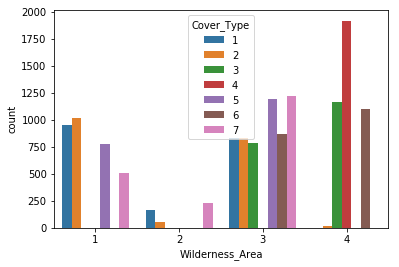

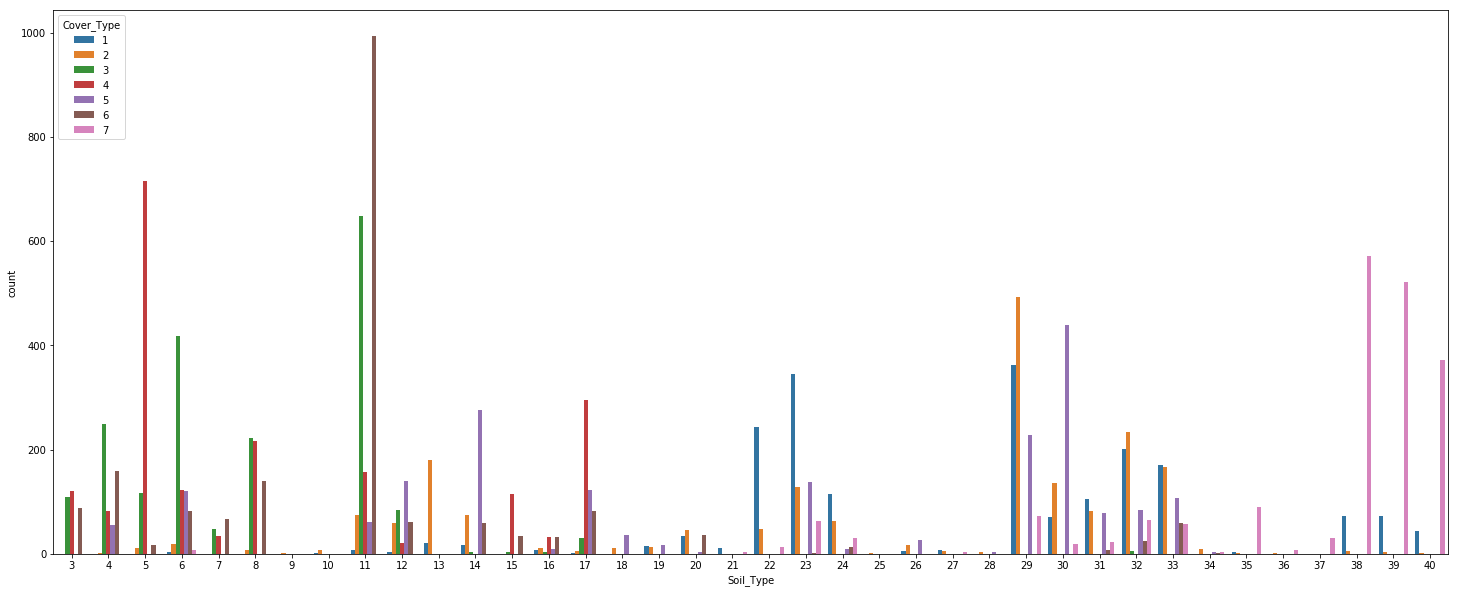

In [39]:
%matplotlib inline

# Group one-hot encoded variables of a category into one single variable

#names of all the columns
cols = TrainDataPrep.columns

#number of rows=r , number of columns=c
r,c = TrainDataPrep.shape

#Create a new dataframe with r rows, one column for each encoded category, and target in the end
data = pd.DataFrame(index=np.arange(0, r),columns=['Wilderness_Area','Soil_Type','Cover_Type'])

#Make an entry in 'data' for each r as category_id, target value
for i in range(0,r):
    w=0;
    s=0;
    # Category1 range
    for j in range(10,14):
        if (TrainDataPrep.iloc[i,j] == 1):
            w=j-9  #category class
            break
    # Category2 range        
    for k in range(14,54):
        if (TrainDataPrep.iloc[i,k] == 1):
            s=k-11 #category class
            break
    #Make an entry in 'data' for each r as category_id, target value        
    data.iloc[i]=[w,s,TrainDataPrep.iloc[i,c-1]]

#Plot for Category1    
sns.countplot(x="Wilderness_Area", hue="Cover_Type", data=data)
plt.show()
#Plot for Category2
plt.rc("figure", figsize=(25, 10))
sns.countplot(x="Soil_Type", hue="Cover_Type", data=data)
plt.show()

#WildernessArea_4 has a lot of presence for cover_type 4. Good class distinction
#WildernessArea_3 has not much class distinction
#SoilType 1-6,10-14,17, 22-23, 29-33,35,38-40 offer lot of class distinction as counts for some are very high


In [40]:
clftest= ExtraTreesClassifier(n_estimators=c-1,max_features=0.25,n_jobs=-1,random_state=2617)
clftest.fit(Xtrain,Ytrain)
clftest.feature_importances_
Xtestscale.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11',
       'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40'],
      dtype='object')

In [41]:
def FeaturesIndexTab(model, X, Y, val):
    joined=[]
    joined_sorted=[]
    FeaturesKeep=[]
    FeaturesRemoved=[]
    model.fit(X, Y)
    for i, pred in enumerate(list(model.feature_importances_)):
        joined.append([i, cols[i], pred])
    joined_sorted=sorted(joined, key=lambda x: -x[2])
    dropstartindex=int((val * (X.shape[1] - 1)))
    for j, (i, col, x) in enumerate(list(joined_sorted)):
        if j <= dropstartindex:
            FeaturesKeep.append(col)
        else:
            FeaturesRemoved.append(col)
    
    return FeaturesKeep,FeaturesRemoved



#Select top 75%,50%,25%
ratio_list = [0.75,0.50,0.25]


In [42]:

# Feature Selection
seed = 2617

clf_ET = []
clf_RF = []
clf_SVC = []
clf_XGB = []
Feat_ET_Keep = []
Feat_ET_Removed = []
Feat_RF_Keep = []
Feat_RF_Removed = []
Feat_SVM_Keep = []
Feat_SVM_Removed = []
Feat_XGB_Keep = []
Feat_XGB_Removed = []


for i, val in enumerate(ratio_list):
    clf_ET.append(ExtraTreesClassifier(n_estimators=c - 1,
                                       max_features=val, n_jobs=-1, random_state=seed))
    clf_RF.append(RandomForestClassifier(n_estimators=c - 1,
                                         max_features=val, n_jobs=-1, random_state=seed))
    clf_XGB = XGBClassifier(n_estimators=c - 1, seed=seed)
    #clf_SVC = SVC(C=52, decision_function_shape='ovr',
    #                   gamma=0.1555, kernel='rbf')
    ET=FeaturesIndexTab(clf_ET[i], Xtrain, Ytrain, val)
    RF=FeaturesIndexTab(clf_RF[i], Xtrain, Ytrain, val)
    XGB=FeaturesIndexTab(clf_XGB, Xtrainscale, Ytrain, val)
    #SVC=FeaturesIndexTab(clf_SVC, Xtrainscale, Ytrain, val)
    Feat_ET_Keep.append(ET[0])
    Feat_ET_Removed.append(ET[1])
    Feat_RF_Keep.append(RF[0])
    Feat_RF_Removed.append(RF[1])
    Feat_XGB_Keep.append(XGB[0])
    Feat_XGB_Removed.append(XGB[1])
    
Feat_SVM_Keep = Feat_ET_Keep
Feat_SVM_Removed = Feat_ET_Removed
print(Feat_ET_Keep)

[['Elevation', 'Wilderness_Area4', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Hillshade_9am', 'Aspect', 'Hillshade_Noon', 'Soil_Type10', 'Hillshade_3pm', 'Slope', 'Soil_Type38', 'Soil_Type3', 'Soil_Type39', 'Soil_Type4', 'Wilderness_Area3', 'Wilderness_Area1', 'Soil_Type40', 'Soil_Type2', 'Soil_Type30', 'Soil_Type17', 'Soil_Type32', 'Soil_Type23', 'Soil_Type13', 'Soil_Type12', 'Soil_Type22', 'Soil_Type11', 'Soil_Type29', 'Soil_Type33', 'Soil_Type31', 'Soil_Type6', 'Soil_Type24', 'Soil_Type35', 'Wilderness_Area2', 'Soil_Type20', 'Soil_Type1', 'Soil_Type5', 'Soil_Type18'], ['Elevation', 'Horizontal_Distance_To_Roadways', 'Wilderness_Area4', 'Horizontal_Distance_To_Fire_Points', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Aspect', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Slope', 'Soil_Type10', 'Soil_Type38', 'Soil_Type39', 'Soil_Type3', 'Wilderness_Ar

In [43]:
#SVM
C=[100]
gamma =[10**(-4)]
decision_func =['ovr']

#25 % of subset
clf_25=GridSearchSVM(Xtrainscale[Feat_SVM_Keep[2]],Ytrain,gamma,C,decision_func,10)
    
print('SVM Not F', clf_25.best_params_)
Ypred_scale = clf_25.predict(Xtestscale[Feat_SVM_Keep[2]])
Error1 = np.count_nonzero(Ytest-Ypred_scale)/len(Ytest)
print('Test std: ',1-Error1)
Ysubmission_SVM_25 = clf_25.predict(XtestFinalscale[Feat_SVM_Keep[2]])    
writeres(TestData,Ysubmission_SVM_25,'SVM_25.csv')

#50 % of subset
clf_50=GridSearchSVM(Xtrainscale[Feat_SVM_Keep[1]],Ytrain,gamma,C,decision_func,10)
    
print('SVM Not F', clf_50.best_params_)
Ypred_scale = clf_50.predict(Xtestscale[Feat_SVM_Keep[1]])
Error1 = np.count_nonzero(Ytest-Ypred_scale)/len(Ytest)
print('Test std: ',1-Error1)
Ysubmission_SVM_50 = clf_50.predict(XtestFinalscale[Feat_SVM_Keep[1]])    
writeres(TestData,Ysubmission_SVM_50,'SVM_50.csv')





Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  1.2min remaining:   46.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.7min finished


SVM Not F {'C': 100, 'decision_function_shape': 'ovr', 'gamma': 0.0001, 'kernel': 'rbf'}
Test std:  0.5773809523809523
SVM_25.csv 2    5511
1    3703
5    3573
7    2575
3    2503
6    1369
4     766
Name: Cover_Type, dtype: int64
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  1.4min remaining:   57.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.1min finished


SVM Not F {'C': 100, 'decision_function_shape': 'ovr', 'gamma': 0.0001, 'kernel': 'rbf'}
Test std:  0.6170634920634921
SVM_50.csv 2    5073
1    3898
5    3888
3    2567
7    2457
6    1787
4     330
Name: Cover_Type, dtype: int64


In [49]:
#75 % of subset
clf=GridSearchSVM(Xtrainscale[Feat_SVM_Keep[0]],Ytrain,gamma,C,decision_func,10)
    
print('SVM Not F', clf.best_params_)
Ypred_scale = clf.predict(Xtestscale[Feat_SVM_Keep[0]])
Error1 = np.count_nonzero(Ytest-Ypred_scale)/len(Ytest)
print('Test std: ',1-Error1)
Ysubmission_SVM_75 = clf.predict(XtestFinalscale[Feat_SVM_Keep[0]])    
writeres(TestData,Ysubmission_SVM_75,'SVM_75.csv')


#100 % of subset
clf_100=GridSearchSVM(Xtrainscale,Ytrain,gamma,C,decision_func,10)
    
print('SVM Not F', clf_100.best_params_)
Ypred_scale = clf_100.predict(Xtestscale)
Error1 = np.count_nonzero(Ytest-Ypred_scale)/len(Ytest)
print('Test std: ',1-Error1)
Ysubmission_SVM_100 = clf_100.predict(XtestFinalscale)    
writeres(TestData,Ysubmission_SVM_100,'SVM_100.csv')

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  2.4min finished


SVM Not F {'C': 52, 'decision_function_shape': 'ovr', 'gamma': 0.1575, 'kernel': 'rbf'}
Test std:  0.8525132275132274
SVM_75.csv 2    7154
1    5100
6    3788
3    2945
5     477
7     413
4     123
Name: Cover_Type, dtype: int64
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  2.7min finished


SVM Not F {'C': 52, 'decision_function_shape': 'ovr', 'gamma': 0.1555, 'kernel': 'rbf'}
Test std:  0.8531746031746031
SVM_100.csv 2    7348
1    5006
6    3706
3    2946
5     445
7     415
4     134
Name: Cover_Type, dtype: int64


In [50]:
#
n = [1000]
boot=[False] 
cw=[ 'balanced']
#25
clf_et_25= ET(Xtrain[Feat_ET_Keep[2]],Ytrain,n,boot,cw,5)
print('ET Not F', clf_et_25.best_params_)
print('ET std',clf_et_25.score(Xtest[Feat_ET_Keep[2]],Ytest))
Ysubmission_ET_25 = clf_et_25.predict(XtestFinal[Feat_ET_Keep[2]])    
writeres(TestData,Ysubmission_ET_25, 'ET_25.csv')

#50
clf_et_50= ET(Xtrain[Feat_ET_Keep[1]],Ytrain,n,boot,cw,5)
print('ET Not F', clf_et_50.best_params_)
print('ET std',clf_et_50.score(Xtest[Feat_ET_Keep[1]],Ytest))
Ysubmission_ET_50 = clf_et_50.predict(XtestFinal[Feat_ET_Keep[1]])    
writeres(TestData,Ysubmission_ET_50, 'ET_50.csv')

#75
clf_et_75= ET(Xtrain[Feat_ET_Keep[0]],Ytrain,n,boot,cw,5)
print('ET Not F', clf_et_75.best_params_)
print('ET std',clf_et_75.score(Xtest[Feat_ET_Keep[0]],Ytest))
Ysubmission_ET_75 = clf_et_75.predict(XtestFinal[Feat_ET_Keep[0]])    
writeres(TestData,Ysubmission_ET_75, 'ET_75.csv')

#100
clf_et= ET(Xtrain,Ytrain,n,boot,cw,5)
print('ET Not F', clf_et.best_params_)
print('ET std',clf_et.score(Xtest,Ytest))
Ysubmission_ET = clf_et.predict(XtestFinal)    
writeres(TestData,Ysubmission_ET, 'ET_100.csv')



Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   30.5s remaining:   45.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.4s finished


ET Not F {'bootstrap': False, 'class_weight': 'balanced', 'max_features': None, 'n_estimators': 1000, 'random_state': 2617}
ET std 0.86044973545
ET_25.csv 2    7319
1    6393
6    2250
3    1715
5    1330
7     993
Name: Cover_Type, dtype: int64
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   35.5s remaining:   53.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   39.3s finished


ET Not F {'bootstrap': False, 'class_weight': 'balanced', 'max_features': None, 'n_estimators': 1000, 'random_state': 2617}
ET std 0.878306878307
ET_50.csv 2    7951
1    7039
6    2156
3    1295
5    1237
7     322
Name: Cover_Type, dtype: int64
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   47.2s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   49.6s finished


ET Not F {'bootstrap': False, 'class_weight': 'balanced', 'max_features': None, 'n_estimators': 1000, 'random_state': 2617}
ET std 0.884920634921
ET_75.csv 2    8177
1    7049
6    1876
3    1560
5    1107
7     231
Name: Cover_Type, dtype: int64
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   52.1s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   55.2s finished


ET Not F {'bootstrap': False, 'class_weight': 'balanced', 'max_features': None, 'n_estimators': 1000, 'random_state': 2617}
ET std 0.888227513228
ET_100.csv 2    8304
1    6929
6    1846
3    1590
5    1091
7     240
Name: Cover_Type, dtype: int64


In [55]:
#XGBOOST


#25
clf_XGB_25=XGBClassifier(n_estimators=300, seed=seed,subsample=0.25)
clf_XGB_25.fit(Xtrainscale[Feat_XGB_Keep[2]],Ytrain)
print('XGB std',clf_XGB_25.score(Xtestscale[Feat_XGB_Keep[2]],Ytest))
Ysubmission_XGB_25 = clf_XGB_25.predict(XtestFinalscale[Feat_XGB_Keep[2]])    
writeres(TestData,Ysubmission_XGB_25, 'XGB_25.csv')

#50
clf_XGB_50=XGBClassifier(n_estimators=300, seed=seed,subsample=0.5)
clf_XGB_50.fit(Xtrainscale[Feat_XGB_Keep[1]],Ytrain)
print('XGB std',clf_XGB_50.score(Xtestscale[Feat_XGB_Keep[1]],Ytest))
Ysubmission_XGB_50 = clf_XGB_50.predict(XtestFinalscale[Feat_XGB_Keep[1]])    
writeres(TestData,Ysubmission_XGB_50, 'XGB_50.csv')

#75
clf_XGB_75=XGBClassifier(n_estimators=300, seed=seed,subsample=0.75)
clf_XGB_75.fit(Xtrainscale[Feat_XGB_Keep[0]],Ytrain)
print('XGB std',clf_XGB_75.score(Xtestscale[Feat_XGB_Keep[0]],Ytest))
Ysubmission_XGB_75 = clf_XGB_75.predict(XtestFinalscale[Feat_XGB_Keep[0]])    
writeres(TestData,Ysubmission_XGB_75, 'XGB_75.csv')

#100
clf_XGB_100=XGBClassifier(n_estimators=300, seed=seed)
clf_XGB_100.fit(Xtrainscale,Ytrain)
print('XGB std',clf_XGB_100.score(Xtestscale,Ytest))
Ysubmission_XGB = clf_XGB_100.predict(XtestFinalscale)    
writeres(TestData,Ysubmission_XGB, 'XGB_100.csv')


XGB std 0.781084656085
XGB_25.csv 1    6276
6    3517
4    3490
2    3269
3    2530
7     655
5     263
Name: Cover_Type, dtype: int64
XGB std 0.785714285714
XGB_50.csv 6    6619
1    5823
2    3908
3    1890
7     755
4     614
5     391
Name: Cover_Type, dtype: int64
XGB std 0.820105820106
XGB_75.csv 6    5708
1    5630
2    4027
3    3169
7     756
4     440
5     270
Name: Cover_Type, dtype: int64
XGB std 0.816137566138
XGB_100.csv 1    5890
6    5790
3    3652
2    3461
7     823
5     365
4      19
Name: Cover_Type, dtype: int64


In [17]:
n = [500]
boot=[False] 
cw=[ 'balanced']
#RF 25
clf_rf_25 = RandomClassifier(Xtrain[Feat_RF_Keep[2]],Ytrain,n,boot,cw,5)
print('RF Not F', clf_rf_25.best_params_)
print('RF non Std', clf_rf_25.score(Xtest[Feat_RF_Keep[2]],Ytest))
Ysubmission_RF_25 = clf_rf_25.predict(XtestFinal[Feat_RF_Keep[2]])    
writeres(TestData,Ysubmission_RF_25, 'RF_25.csv')
#RF 50
clf_rf_50 = RandomClassifier(Xtrain[Feat_RF_Keep[1]],Ytrain,n,boot,cw,5)
print('RF Not F', clf_rf_50.best_params_)
print('RF non Std', clf_rf_50.score(Xtest[Feat_RF_Keep[1]],Ytest))
Ysubmission_RF_50 = clf_rf_50.predict(XtestFinal[Feat_RF_Keep[1]])    
writeres(TestData,Ysubmission_RF_50, 'RF_50.csv')
#RF 75
clf_rf_75 = RandomClassifier(Xtrain[Feat_RF_Keep[0]],Ytrain,n,boot,cw,5)
print('RF Not F', clf_rf_75.best_params_)
print('RF non Std', clf_rf_75.score(Xtest[Feat_RF_Keep[0]],Ytest))
Ysubmission_RF_75 = clf_rf_75.predict(XtestFinal[Feat_RF_Keep[0]])    
writeres(TestData,Ysubmission_RF_75, 'RF_75.csv')
#RF all
clf_rf = RandomClassifier(Xtrain,Ytrain,n,boot,cw,5)
print('RF Not F', clf_rf.best_params_)
print('RF non Std', clf_rf.score(Xtest,Ytest))
Ysubmission_RF_100 = clf_rf.predict(XtestFinal)    
writeres(TestData,Ysubmission_RF_100, 'RF_100.csv')




Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   38.8s finished


RF Not F {'bootstrap': False, 'class_weight': 'balanced', 'n_estimators': 500}
RF non Std 0.843915343915
RF_25.csv 2    7422
1    6592
6    2510
3    1460
5    1186
7     830
Name: Cover_Type, dtype: int64
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   39.8s finished


RF Not F {'bootstrap': False, 'class_weight': 'balanced', 'n_estimators': 500}
RF non Std 0.849206349206
RF_50.csv 2    7630
1    6996
6    2193
5    1321
3    1174
7     686
Name: Cover_Type, dtype: int64
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   38.3s finished


RF Not F {'bootstrap': False, 'class_weight': 'balanced', 'n_estimators': 500}
RF non Std 0.857804232804
RF_75.csv 2    7871
1    7171
6    1959
3    1393
5    1165
7     441
Name: Cover_Type, dtype: int64
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   40.1s finished


RF Not F {'bootstrap': False, 'class_weight': 'balanced', 'n_estimators': 500}
RF non Std 0.855158730159
RF_100.csv 2    7855
1    7171
6    1995
3    1402
5    1128
7     449
Name: Cover_Type, dtype: int64


In [44]:
# MLPClassifier
clf_mlpc = clf = MLPClassifier(
    solver='adam', alpha=1 * 10**(-5), hidden_layer_sizes=(Xtrain.shape[1] * 4, 
                                                           int(Xtrain.shape[1]*2), 
                                                           int(Xtrain.shape[1]),
                                                           int(Xtrain.shape[1]/2),
                                                           int(Xtrain.shape[1]/4)), 
                                                           random_state = 2617)
clf_mlpc.fit(Xtrainscale, Ytrain)
print(clf_mlpc.score(Xtestscale, Ytest))
Ysubmission_RF_100=clf_mlpc.predict(XtestFinalscale)
writeres(TestData, Ysubmission_RF_100, 'MPL_100.csv')

0.816798941799
MPL_100.csv 2    6424
6    5356
1    4635
3    2190
7     585
4     577
5     233
Name: Cover_Type, dtype: int64


In [20]:
# polynonmial features and ET
poly = PolynomialFeatures(3, interaction_only=True)
XtrainPoly = pd.DataFrame(poly.fit_transform(Xtrain.iloc[:, :8]), index=Xtrain.index)
XtestPoly = pd.DataFrame(poly.fit_transform(Xtest.iloc[:, :8]), index= Xtest.index)
XtestFinalPoly = pd.DataFrame(poly.fit_transform(XtestFinal.iloc[:, :8]), index=XtestFinal.index)

XtrainPolyTotal = pd.concat([XtrainPoly, Xtrain.iloc[:, 8:]], axis=1)
XtestPolyTotal = pd.concat([XtestPoly, Xtest.iloc[:, 8:]], axis=1)
XtestFinalPolyTotal = pd.concat([XtestFinalPoly, XtestFinal.iloc[:, 8:]], axis=1)


# Top 10
clf_et_10 = ExtraTreesClassifier(n_estimators=200, criterion='gini', max_depth=None, 
                     min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                     max_features=15, max_leaf_nodes=None, min_impurity_decrease=0.0, 
                     min_impurity_split=None, bootstrap=False, oob_score=False, n_jobs=1, 
                     random_state=None, verbose=0, warm_start=False, class_weight=None)
clf_et_15 = ExtraTreesClassifier(n_estimators=200, criterion='gini', max_depth=None, 
                     min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                     max_features=25, max_leaf_nodes=None, min_impurity_decrease=0.0, 
                     min_impurity_split=None, bootstrap=False, oob_score=False, n_jobs=1, 
                     random_state=None, verbose=0, warm_start=False, class_weight=None)
clf_et_20 = ExtraTreesClassifier(n_estimators=500, criterion='gini', max_depth=None, 
                     min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                     max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, 
                     min_impurity_split=None, bootstrap=False, oob_score=False, n_jobs=1, 
                     random_state=None, verbose=0, warm_start=False, class_weight=None)

clf_et_10.fit(XtrainPolyTotal, Ytrain)
print ('Et_Poly 10 best parameters ',clf_et_10.score(XtestPolyTotal, Ytest))
clf_et_15.fit(XtrainPolyTotal, Ytrain)
print ('Et_Poly 15 best parameters ',clf_et_15.score(XtestPolyTotal, Ytest))
clf_et_20.fit(XtrainPolyTotal, Ytrain)
print ('Et_Poly 20 best parameters ',clf_et_20.score(XtestPolyTotal, Ytest))
Ysubmission_ET_Poly_10 =clf_et_10.predict(XtestFinalPolyTotal)
Ysubmission_ET_Poly_15 =clf_et_15.predict(XtestFinalPolyTotal)
Ysubmission_ET_Poly_20 =clf_et_20.predict(XtestFinalPolyTotal)
writeres(TestData, Ysubmission_ET_Poly_10, 'ET_Poly_10.csv')
writeres(TestData, Ysubmission_ET_Poly_15, 'ET_Poly_15.csv')
writeres(TestData, Ysubmission_ET_Poly_20, 'ET_Poly_20.csv')


Et_Poly 10 best parameters  0.855158730159
Et_Poly 15 best parameters  0.867724867725
Et_Poly 20 best parameters  0.882275132275
ET_Poly_10.csv 1    7912
2    7535
6    1756
3    1298
5    1168
7     331
Name: Cover_Type, dtype: int64
ET_Poly_15.csv 1    7727
2    7713
6    1743
3    1280
5    1191
7     346
Name: Cover_Type, dtype: int64
ET_Poly_20.csv 2    8173
1    7097
6    1630
3    1546
5    1231
7     323
Name: Cover_Type, dtype: int64


In [17]:
#Hypothesis class distribution of the sample test would be the same as the final
#Data Leakage
d = dict()
d ={2:0.64770, 1:0.32240, 6:0.01475, 3:0.01060, 7:0.0025, 5:0.002 }
clf_et_10 = ExtraTreesClassifier(n_estimators=200, criterion='gini', max_depth=None, 
                     min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                     max_features=15, max_leaf_nodes=None, min_impurity_decrease=0.0, 
                     min_impurity_split=None, bootstrap=False, oob_score=False, n_jobs=1, 
                     random_state=None, verbose=0, warm_start=False, class_weight=d)
clf_et_15 = ExtraTreesClassifier(n_estimators=200, criterion='gini', max_depth=None, 
                     min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                     max_features=25, max_leaf_nodes=None, min_impurity_decrease=0.0, 
                     min_impurity_split=None, bootstrap=False, oob_score=False, n_jobs=1, 
                     random_state=None, verbose=0, warm_start=False, class_weight=d)
clf_et_20 = ExtraTreesClassifier(n_estimators=500, criterion='gini', max_depth=None, 
                     min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                     max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, 
                     min_impurity_split=None, bootstrap=False, oob_score=False, n_jobs=1, 
                     random_state=None, verbose=0, warm_start=False, class_weight=d)

clf_et_10.fit(Xtrain, Ytrain)
print ('Et_Poly 10 best parameters ',clf_et_10.score(Xtest, Ytest))
clf_et_15.fit(Xtrain, Ytrain)
print ('Et_Poly 15 best parameters ',clf_et_15.score(Xtest, Ytest))
clf_et_20.fit(Xtrain, Ytrain)
print ('Et_Poly 20 best parameters ',clf_et_20.score(Xtest, Ytest))
Ysubmission_ET_W_10 =clf_et_10.predict(XtestFinal)
Ysubmission_ET_W_15 =clf_et_15.predict(XtestFinal)
Ysubmission_ET_W_20 =clf_et_20.predict(XtestFinal)
writeres(TestData, Ysubmission_ET_W_10, 'ET_Poly_10.csv')
writeres(TestData, Ysubmission_ET_W_15, 'ET_Poly_15.csv')
writeres(TestData, Ysubmission_ET_W_20, 'ET_Poly_20.csv')





Et_Poly 10 best parameters  0.861772486772
Et_Poly 15 best parameters  0.861772486772
Et_Poly 20 best parameters  0.863095238095
ET_Poly_10.csv 1    7391
2    7177
6    1843
3    1663
5    1592
7     334
Name: Cover_Type, dtype: int64
ET_Poly_15.csv 1    7295
2    7039
6    1860
5    1717
3    1625
7     464
Name: Cover_Type, dtype: int64
ET_Poly_20.csv 1    7279
2    7061
6    1975
5    1716
3    1544
7     425
Name: Cover_Type, dtype: int64


In [33]:
# How to cheat
TrainDataBis = pd.read_csv(
        "/home/joseph/Dropbox/DeepLearning/Programmation/KaggleCompetition/train-data.csv", sep=",")
TestDataBis = pd.read_csv(
        "/home/joseph/Dropbox/DeepLearning/Programmation/KaggleCompetition/test-data.csv", sep=",")

CheatData = pd.read_csv("/home/joseph/Dropbox/DeepLearning/Programmation/KaggleCompetition/covtype.data",
                        sep=",", names=TrainDataBis.columns[1:])

In [34]:
CheatData.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


In [35]:
TestDataBis.describe()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.0,20000.000000,20000.000000,20000.0,20000.0,20000.000000,20000.000000,20000.000000,20000.0,20000.0,20000.0,20000.0,20000.0,20000.000000,20000.00000,20000.0,20000.000000,20000.000000,20000.0,20000.000000,20000.000000,20000.0,20000.000000,20000.000000,20000.0,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000,20000.0,20000.0,20000.0,20000.0,20000.0,20000.000000,20000.000000,20000.000000,20000.000000,20000.0,20000.0,20000.000000,20000.000000,20000.000000
mean,25120.500000,2966.568300,144.775950,16.934750,255.496650,31.926450,1904.487800,215.040400,229.544700,142.397100,2595.925500,0.0,0.409950,0.590050,0.0,0.0,0.033650,0.051050,0.008700,0.0,0.0,0.0,0.0,0.0,0.079850,0.11680,0.0,0.121350,0.000650,0.0,0.000950,0.011400,0.0,0.004550,0.013200,0.0,0.108850,0.086300,0.028200,0.02365,0.013750,0.0,0.0,0.0,0.0,0.0,0.105000,0.085950,0.031700,0.024850,0.0,0.0,0.032700,0.009700,0.007200
std,5773.647028,296.970825,84.633988,7.476255,189.688825,56.467422,1164.492291,24.907412,20.342033,36.651345,1377.446291,0.0,0.491836,0.491836,0.0,0.0,0.180331,0.220105,0.092869,0.0,0.0,0.0,0.0,0.0,0.271068,0.32119,0.0,0.326542,0.025487,0.0,0.030808,0.106163,0.0,0.067302,0.114133,0.0,0.311459,0.280814,0.165548,0.15196,0.116454,0.0,0.0,0.0,0.0,0.0,0.306561,0.280297,0.175205,0.155672,0.0,0.0,0.177855,0.098012,0.084549
min,15121.000000,2382.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,77.000000,141.000000,0.000000,228.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
25%,20120.750000,2673.000000,71.000000,11.000000,108.000000,0.000000,930.000000,201.000000,216.000000,116.000000,1465.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
50%,25120.500000,2972.000000,148.000000,16.000000,216.000000,18.000000,1767.500000,220.000000,233.000000,140.000000,2273.000000,0.0,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
75%,30120.250000,3241.000000,204.000000,22.000000,361.000000,57.000000,2774.000000,234.000000,248.000000,169.000000,3772.000000,0.0,1.000000,1.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
max,35120.000000,3472.000000,360.000000,44.000000,1034.000000,309.000000,4738.000000,254.0000

In [36]:
Res =CheatData.merge(TestDataBis,on= [ c for c in TestDataBis.columns[1:]], right_index=True)

In [37]:
Res['Cover_Type'].value_counts()/20000

2    0.64770
1    0.32240
6    0.01475
3    0.01060
7    0.00255
5    0.00200
Name: Cover_Type, dtype: float64

In [38]:
Res[['Id', 'Cover_Type']].to_csv(
    '/home/joseph/Dropbox/DeepLearning/Programmation/KaggleCompetition/Cheat.csv', sep=',', index=False)

In [42]:
                             
clf_svc_w_ = SVC(C=52, kernel='rbf',  gamma=0.1555,
                 decision_function_shape='ovr', 
                random_state=seed,class_weight=d)
clf_svc_w_.fit(XtestFinalscale,Res['Cover_Type'])
Ypred_scale = clf_svc_w_.predict(XtestFinalscale)
Error1 = np.count_nonzero(Res['Cover_Type']-Ypred_scale)/len(Res['Cover_Type'])
print('Test std 75: ',1-Error1)
Ysubmission_SVM_ = clf_svc_w_.predict(XtestFinalscale)    
writeres(TestData,Ysubmission_SVM_,'SVM_.csv')

Test std 75:  0.96155
SVM_.csv 2    13594
1     6294
6       72
3       40
Name: Cover_Type, dtype: int64
